In [6]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 컨텍스트 격리: 하위 에이전트

<img src="./assets/agent_header_subagent.png" width="800" style="display:block; margin-left:0;">

대화가 진행됨에 따라 에이전트 컨텍스트는 빠르게 증가할 수 있으며, 이는 여러 가지 긴 컨텍스트 관련 문제를 야기합니다. 주요 문제점은 동일한 컨텍스트 창 내에서 혼합된 목표가 최적의 성능을 저해할 수 있는 컨텍스트 충돌 또는 혼란입니다. [컨텍스트 격리](https://blog.langchain.com/context-engineering-for-agents/)는 [전문 하위 에이전트](https://www.anthropic.com/engineering/multi-agent-research-system)에 작업을 위임하여 효과적인 솔루션을 제공하며, 각 하위 에이전트는 자체 격리된 컨텍스트 창 내에서 작동합니다. 이 접근 방식은 컨텍스트 충돌, 혼란, 오염 및 희석을 방지하는 동시에 집중적이고 전문화된 작업 실행을 가능하게 합니다.



### 하위 에이전트 위임
![./assets/subagents.png](./assets/subagents.png)
주요 통찰은 특정 작업에 맞춰진 다양한 도구 세트를 가진 하위 에이전트를 생성할 수 있다는 것입니다. 각 하위 에이전트는 `subagent_type`을 키로 하는 레지스트리 사전에 저장되어, 메인 에이전트가 `task(description, subagent_type)` 도구 호출을 통해 작업을 위임할 수 있습니다. 하위 에이전트는 부모의 컨텍스트와 완전히 분리되어 작동하며, 그 결과는 `ToolMessage`로 부모 에이전트에 반환되어 관심사의 깔끔한 분리를 유지합니다.

## 단계 1: 하위 에이전트 생성

사용자가 하위 에이전트를 지정하는 방법을 정의해봅시다.
```python
from typing_extensions import TypedDict

class SubAgent(TypedDict):
    """전문화된 하위 에이전트를 위한 구성."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]
```

우리는 이러한 객체의 목록을 사용하여 액세스할 수 있는 모든 하위 에이전트를 생성합니다.

```python
agents: list[SubAgent] = ...
subagents = {
    agent['name']: create_react_agent(
        model=model,
        prompt=agent['prompt'],
        tools = get_tools(agent['tools']),
        ...
    )
}
```

## 단계 2: 하위 에이전트를 사용하는 도구 생성

논리적으로는 다음과 같아야 합니다:

```python
def task(
    description: str  # 하위 에이전트가 수행해야 할 작업
    subagent_type: str  # 사용할 하위 에이전트
):
    # 하위 에이전트에 전달할 새 메시지 생성 - 설명만 있어야 함
    # 하위 에이전트 호출
    # 상태를 하위 에이전트의 응답과 파일 시스템의 모든 변경 사항으로 업데이트
```

최종적으로는 다음과 같이 됩니다:

```python
@tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
def task(
    description: str,
    subagent_type: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
):
    """작업을 격리된 컨텍스트를 가진 전문화된 하위 에이전트에게 위임합니다.

    이는 작업 설명만 포함하는 하위 에이전트를 위한 신선한 컨텍스트를 생성하여
    부모 에이전트의 대화 기록으로부터의 컨텍스트 오염을 방지합니다.
    """
    # 요청된 에이전트 타입이 존재하는지 검증
    if subagent_type not in agents:
        return f"오류: {subagent_type} 타입의 에이전트를 호출했습니다. 허용된 타입은 {[f'`{k}`' for k in agents]}입니다."

    # 요청된 하위 에이전트 가져오기
    sub_agent = agents[subagent_type]

    # 작업 설명만 포함하는 격리된 컨텍스트 생성
    # 이것이 컨텍스트 격리의 핵심 - 부모 기록 없음
    state["messages"] = [{"role": "user", "content": description}]

    # 격리된 상태에서 하위 에이전트 실행
    result = sub_agent.invoke(state)

    # 명령 상태 업데이트를 통해 부모 에이전트에 결과 반환
    return Command(
        update={
            "files": result.get("files", {}),  # 파일 변경 사항 병합
            "messages": [
                # 하위 에이전트 결과가 부모 컨텍스트의 ToolMessage가 됨
                ToolMessage(
                    result["messages"][-1].content, tool_call_id=tool_call_id
                )
            ],
        }
    )

return task
```

In [7]:
%%writefile ../src/deep_agents_from_scratch/task_tool.py
"""Task delegation tools for context isolation through sub-agents.

This module provides the core infrastructure for creating and managing sub-agents
with isolated contexts. Sub-agents prevent context clash by operating with clean
context windows containing only their specific task description.
"""

from typing import Annotated, NotRequired
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.types import Command

from deep_agents_from_scratch.prompts import TASK_DESCRIPTION_PREFIX
from deep_agents_from_scratch.state import DeepAgentState


class SubAgent(TypedDict):
    """Configuration for a specialized sub-agent."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts, preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools: List of available tools that can be assigned to sub-agents
        subagents: List of specialized sub-agent configurations
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' tool that can delegate work to specialized sub-agents
    """
    # Create agent registry
    agents = {}

    # Build tool name mapping for selective tool assignment
    tools_by_name = {}
    for tool_ in tools:
        if not isinstance(tool_, BaseTool):
            tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_

    # Create specialized sub-agents based on configurations
    for _agent in subagents:
        if "tools" in _agent:
            # Use specific tools if specified
            _tools = [tools_by_name[t] for t in _agent["tools"]]
        else:
            # Default to all tools
            _tools = tools
        agents[_agent["name"]] = create_react_agent(
            model, prompt=_agent["prompt"], tools=_tools, state_schema=state_schema
        )

    # Generate description of available sub-agents for the tool description
    other_agents_string = [
        f"- {_agent['name']}: {_agent['description']}" for _agent in subagents
    ]

    @tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
    def task(
        description: str,
        subagent_type: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Delegate a task to a specialized sub-agent with isolated context.

        This creates a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """
        # Validate requested agent type exists
        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"

        # Get the requested sub-agent
        sub_agent = agents[subagent_type]

        # Create isolated context with only the task description
        # This is the key to context isolation - no parent history
        state["messages"] = [{"role": "user", "content": description}]

        # Execute the sub-agent in isolation
        result = sub_agent.invoke(state)

        # Return results to parent agent via Command state update
        return Command(
            update={
                "files": result.get("files", {}),  # Merge any file changes
                "messages": [
                    # Sub-agent result becomes a ToolMessage in parent context
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ],
            }
        )

    return task

Overwriting ../src/deep_agents_from_scratch/task_tool.py


이제 하위 에이전트를 도구로 생성할 루틴이 있습니다. 이제 특정 하위 에이전트를 정의하고 시스템이 `task` 도구로 이들을 호출하도록 할 수 있습니다.    
위의 `_create_task_tool`은 `SubAgent` 타입의 목록을 받습니다. 이 목록은 생성될 에이전트들의 설명을 포함합니다. 

```python
class SubAgent(TypedDict):
    """Configuration for a specialized sub-agent."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

```
`SubAgent` 클래스는 하위 에이전트의 이중 역할을 만족하기 위해 필요한 고유 정보를 정의합니다. 하위 에이전트는 도구와 에이전트 모두로 작동합니다.  

- **도구로서**, 감독 에이전트에 자신의 능력과 호출 방법에 대한 정보를 제공합니다.  
- **에이전트로서**, 작업을 수행하는 방법을 설명하는 프롬프트와 해당 작업을 위한 도구 세트가 필요합니다.  

아래에서 연구 하위 에이전트를 생성합니다. 그 `description`은 감독 에이전트에 단일 작업이 이 하위 에이전트에게 위임되어야 함을 알립니다. `SIMPLE_RESEARCH_INSTRUCTIONS`는 하위 에이전트가 연구를 지시하는 데 사용하는 프롬프트입니다. 이 예제에서는 간략하지만, 범용 연구자의 경우 훨씬 더 상세할 수 있습니다. 하위 에이전트에는 연구 중에 사용할 `web_search` 도구도 제공됩니다.  

```python
# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}
```

Note that the sub-agent receives a specific task, along with the necessary tools to complete it. It operates in its own context, limited to the single task description. This [context-engineering](https://blog.langchain.com/context-engineering-for-agents/) approach ensures that the subagent’s working context remains free of context clashes, confusion, poisoning, and dilution.

감독 에이전트 프롬프트는 이제 이러한 하위 에이전트를 호출하고 사용하는 방법에 대한 설명을 포함해야 합니다. 아래에 표시됩니다. *사용 가능한 도구* 설명과 해당하는 경우 병렬 연구를 사용하는 지침을 주목하세요.

In [8]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS

show_prompt(SUBAGENT_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your role is to coordinate research by delegating specific research tasks to sub-agents.                       │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents                     │
│     - description: Clear, specific research question or task                                                    │
│     - subagent_type: Type of agent to use (e.g., "research-agent")                                              │
│  2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.              │
│     - reflection: Your detailed reflection on the results of the task and next steps.                           │
│                                                                                                                 │
│  **PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task**      │
│  tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units}      │
│  parallel agents per iteration.                                                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Task Delegation Budgets** (Prevent excessive delegation):                                                    │
│  - **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly        │
│  beneficial or when you have multiple independent research directions based on the user's request.              │
│  - **Stop when adequate** - Don't over-research; stop when you have sufficient information                      │
│  - **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found          │
│  adequate sources                                                                                               │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Scaling Rules>                                                                                                │
│  **Simple fact-finding, lists, and rankings** can use a single sub-agent:                                       │
│  - *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in                       │
│  `findings_coffee_shops.md`                                                                                     │
│                                                                                                                 │
│  **Comparisons** can use a sub-agent for each element 

이제 감독자와 하위 에이전트가 있는 연구 시스템을 구축해봅시다. 이것은 조각들이 어떻게 함께 작동하는지를 시연하기 위해 사전 정의된 검색 결과가 있는 모의 버전입니다. 다음 강의에서는 완전한 연구 시스템을 구축할 것입니다.

E0000 00:00:1760675881.403137  541173 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


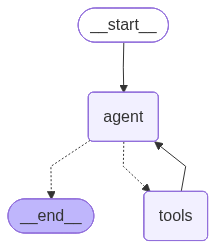

In [9]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from the search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """You are a researcher. Research the topic provided to you. IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic."""

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}

# Create agent using create_react_agent directly
model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)

# Tools for sub-agent
sub_agent_tools = [web_search]

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# Tools
delegation_tools = [task_tool]

# Create agent with system prompt
agent = create_react_agent(
    model,
    delegation_tools,
    prompt=SUBAGENT_USAGE_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
        date=datetime.now().strftime("%a %b %-d, %Y"),
    ),
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [10]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Provide an overview of Model Context Protocol (MCP)."                                         │
│ }                                                                                                               │
│    ID: f7d3f022-4d49-44dd-a1f5-645a1a83de67                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol created by Anthropic. Its purpose is to           │
│ facilitate smooth integration between AI models and external systems such as tools, databases, and other        │
│ services. MCP functions as a standardized communication layer, enabling AI models to access and utilize data    │
│ from diverse sources consistently and efficiently. In essence, it streamlines the process of connecting AI      │
│ assistants to external services by offering a unified language for data exchange.                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The initial research provided a good high-level overview of MCP, including its purpose and     │
│ creator. To provide a more comprehensive overview, I need to delve deeper into its key features, how it works,  │
│ and its benefits. I will delegate these as separate research tasks."                                            │
│ }                                                                                                               │
│    ID: 62f6a57f-5dcb-484a-a2fc-9cbb38e1ef66                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: think_tool is not a valid tool, try one of .                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "What are the key features of the Model Context Protocol (MCP)?"                               │
│ }                                                                                                               │
│    ID: c47d3c24-c3a5-476a-9d13-ba01925a0398                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "How does the Model Context Protocol (MCP) work?"                                              │
│ }                                                                                                               │
│    ID: a497f623-1416-4f0b-955b-d1cb511d0309                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "What are the benefits of using the Model Context Protocol (MCP)?"                             │
│ }                                                                                                               │
│    ID: 4053a5b4-1d6e-4f4f-8954-20aa6631094a                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed by Anthropic. Its key features include: │
│                                                                                                                 │
│ *   **Seamless Integration:** It enables smooth integration between AI models and external systems such as      │
│ tools, databases, and other services.                                                                           │
│ *   **Standardized Communication Layer:** MCP acts as a unified communication layer, allowing AI models to      │
│ access and utilize data from various sources consistently and efficiently.                                      │
│ *   **Simplified Data Exchange:** It simplifies the process of connecting AI assistants to external services by │
│ providing a unified language for data exchange.                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol created by Anthropic. Its purpose is to           │
│ facilitate smooth integration between AI models and external systems such as tools, databases, and other        │
│ services. MCP functions as a standardized communication layer, enabling AI models to access and utilize data    │
│ from diverse sources consistently and efficiently. In essence, it streamlines the process of connecting AI      │
│ assistants to external services by offering a unified language for data exchange.                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP), developed by Anthropic, is an open standard protocol designed to facilitate   │
│ seamless integration between AI models and external systems such as tools, databases, and other services. It    │
│ functions as a standardized communication layer, enabling AI models to access and utilize data from diverse     │
│ sources consistently and efficiently. In essence, MCP streamlines the process of connecting AI assistants to    │
│ external services by providing a unified language for data exchange.                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP), developed by Anthropic, is an open standard protocol designed to facilitate   │
│ seamless integration between AI models and external systems such as tools, databases, and other services. It    │
│ functions as a standardized communication layer, enabling AI models to access and utilize data from diverse     │
│ sources consistently and efficiently. In essence, MCP streamlines the process of connecting AI assistants to    │
│ external services by providing a unified language for data exchange.                                            │
│                                                                                                                 │
│ Key aspects of MCP include:                                                                                     │
│                                                                                                                 │
│ *   **Standardized Communication:** It establishes a common framework for AI models to interact with various    │
│ external systems, ensuring consistency in data exchange.                                                        │
│ *   **Enhanced Integration:** MCP simplifies the process of integrating AI models with a wide array of tools    │
│ and services, reducing complexity for developers.                                                               │
│ *   **Efficient Data Access:** By providing a unified language, it allows AI models to efficiently access and   │
│ utilize information from disparate sources.                                                                     │
│ *   **Streamlined Development:** It aims to make the development of AI assistants that leverage external        │
│ capabilities more straightforward and robust.                                                                   │
│                                                                                                                 │
│ In summary, MCP acts as a crucial bridge, allowing AI models to extend their capabilities by effectively        │
│ communicating with and utilizing the vast ecosystem of external data and services.                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/26cc1c2b-e785-4c6d-a2a7-c30a31875fc7/r
<!-- https://smith.langchain.com/public/edc4e672-db9c-457a-953d-f62e7813591c/r -->